In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import os
import torch
from torch import optim as opt
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from sklearn import preprocessing 
from torchvision import transforms
import imageio as iio
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
bs = 48
num_epochs = 100

In [3]:
names = ['Amin','Farzad','Maziar','Mehrdad','Sina','Soheil','Vahid']
name_file = {name:[] for name in names}

for dirname, _, filenames in os.walk('/kaggle/input/arabicpersian-handwritten-cities-for-postal-apps/scan splited/scan splited'):
    filenames = sorted(filenames) # i want it to be on the same order
    for filename in filenames:
        name = dirname[89:]
        name_file[name].append(os.path.join(dirname, filename))

# I just want to take a subset of the dataset

In [4]:
alphabit = "ابتثجحخدذرزسشصضطظعغفقكلمنهويئ"
num_output = len(alphabit)
alphabit = [a for a in alphabit]
print(num_output)

29


In [5]:
def pad_words(targets):
    """
    Padding words to make all of them on the same size
    """
    targets_new = []
    for target in targets:
        pad = 6-len(target)
        targets_new.append(np.concatenate((np.ones(pad),target),axis=0).astype(np.longlong))
        
        
    return targets_new

In [6]:
words = (" خيابان ميدان نمين ديلم مهران كاشان برحوار نائين البرز يزد تبريز سيريك") # only these words will be considerd
words = words*4 # four persons wrote these words
words = words.split(' ')
words.__delitem__(0) # first element is just empty


imgs = []
for name,files in name_file.items():
    if  name.__eq__('Maziar') or name.__eq__('Mehrdad') or name.__eq__('Sina'):
        continue
    for i,file in enumerate(files):
        if i == 12:
            break
        imgs.append(file)
    

targets = [[w for w in word] for word in words]
lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(alphabit)
targets_enc = [lbl_enc.transform(word)+1 for word in targets]
targets_enc = pad_words(targets_enc)
dataset = {'imgs':imgs, "labels":targets_enc}
df = pd.DataFrame(dataset)


# Dataset and DataLoader

In [7]:
class Mydataset(Dataset):
    
    def __init__(self,df,trans=None):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        x = Image.open(self.df['imgs'][idx]).convert('RGB')
        if trans:
            x = trans(x)
        y = self.df['labels'][idx] # +1 i have already add one in the above cell 
        return (x,y)
    
    

In [8]:
# std = torch.tensor([0.0603, 0.0606, 0.0347])
# mean = torch.tensor([[0.8753, 0.8924, 0.9244]])


In [9]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(20,80)),
    transforms.Normalize(mean=(0.8753,0.8924,0.9244),std=(0.0603,0.0606,0.0347))
                           ])
all_imgs = []
dataset = Mydataset(df,trans)

    

train_loader = DataLoader(dataset,batch_size=bs)

    

In [10]:
test =  torch.tensor([ [ [1,2,3],[5,6,4] ],[[1,1,1],[2,2,2]] ])
aaa = torch.argmax(test,dim=1)  
# lbl_enc.inverse_transform
a = [ t.shape for t in aaa]
aaa.shape

lbl_enc.inverse_transform(np.array([6]))

array(['ح'], dtype='<U1')

In [11]:


def decode_pred(y_pred,targets):
    """
    convert numbers to its corresponding characters 
    0 -> blank
    1 -> padding
    y_pred : output of the model [T,bs,num_classes]
    targets : the ground truth [bs,num of characters]
    """
    y_pred = torch.argmax(y_pred,dim=2)  
    # now our tensor is [T,bs] , in each time stamp there is the charecter with the highest probablity 
    y_pred = y_pred.permute(1,0) # [bs,T]
    labels = [decode_word(word) for word in y_pred]
    
    # if 0 then its blank , replace it with ?
    return labels
    
def decode_word(word):
    """
    covert numbers to words
    words shape: [T] the highest probabilty in each time stamp
    """
    characters = []
    for character in word:
        character -= 2 
        if character.item() == -2 :
            characters.append("?")
        elif character.item() == -1:
            characters.append("P")
        else:
            characters.append(lbl_enc.inverse_transform([character]))        
    
    return characters

# Model

In [12]:
feature_map = torch.tensor([48, 84, 5, 20]) # bs,c,h,w

class MyCNN(nn.Module):
    
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv1 = nn.Conv2d(3,12,3,2,padding=1)
        self.conv2 = nn.Conv2d(12,36,3,2,padding=1)
        self.conv3 = nn.Conv2d(36,84,3,1,padding=1)
        
    def forward(self,x):
        x = self.conv1(F.relu(x))
#         print(x.shape)
        x = self.conv2(F.relu(x))
#         print(x.shape)
        x = self.conv3(F.relu(x))
        return x
    
class MyRNN(nn.Module):
    
    def __init__(self,input_size,hidden_size,num_layers,bi):
        super(MyRNN,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers        
        self.bi = bi
        self.D = 2 if self.bi else 1 
        self.gru = nn.GRU(input_size,hidden_size,num_layers,bidirectional=bi,batch_first=True)
        self.linear1 = nn.Linear(self.D*hidden_size,self.D*hidden_size)
        self.linear2 = nn.Linear(self.D*hidden_size,num_output+2) # +1 for the blank ctc
        
        
    def forward(self,x): 
        h0 = torch.zeros(self.D*self.num_layers,x.size(0),self.hidden_size)
        out,hn = self.gru(x,h0)
        out = self.linear1(F.relu(out))
        out = self.linear2(out)
        out = F.log_softmax(out,dim=2)
        
        return out
        
        
# class denseLayer(nn.Module):
#     def __init__
    
    
class MyModel(nn.Module):
    
    def __init__(self,hidden_size,num_layers,bi):
        super(MyModel,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers  
        self.bi = bi
        self.cnn = MyCNN()
        self.rnn = MyRNN(feature_map[1]*feature_map[2],hidden_size,num_layers,bi)
        
    def forward(self,x):
        x = self.cnn(x)
#         print(x.shape) # --> (bs,c,h,w)
        x = x.view(-1,x.shape[3],x.shape[2]*x.shape[1]) # --> (bs,w,h*c)
        
        # i will assume that num of channels is the time_stamps 
        # i've changed my mind :) , w = time_stamps
        # for rnn , we need (time_stamps,bs,featuers)
        
        x = x.permute(1,0,2) 
#         print(x.shape)
        x = self.rnn(x)
        
        return x



# Training

In [13]:
loss_fn =  nn.CTCLoss(blank=0)
model = MyModel(300,2,True)
lr = 1e-3
optim = opt.Adam(model.parameters(),lr=lr) 

batch = next(iter(train_loader))       
train_loss = []
for epoch in range (2000):
    losses = 0
    for batch in train_loader:
        x,y = batch[0],batch[1]
        out = model(batch[0])
        input_lengths = torch.full(size=(x.shape[0],), fill_value=out.shape[0], dtype=torch.long)
        target_lengths = torch.full(size=(x.shape[0],), fill_value=batch[1].size(1), dtype=torch.long)
        optim.zero_grad()
        loss = loss_fn(out,batch[1],input_lengths,target_lengths)
        loss.backward()
        optim.step()
        losses += loss.item()
        
    train_loss.append(losses/len(train_loader))    


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


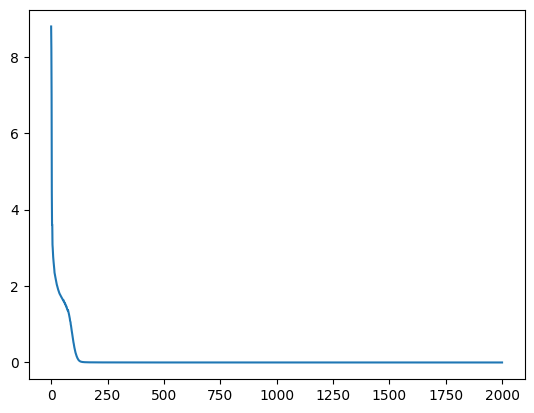

In [14]:
plt.plot(train_loss)

In [15]:
train_loss

[8.790457725524902,
 8.207406044006348,
 6.984409332275391,
 4.438624858856201,
 3.599921226501465,
 3.604987382888794,
 3.0826332569122314,
 2.990666627883911,
 2.8417418003082275,
 2.7634410858154297,
 2.6712048053741455,
 2.620198965072632,
 2.565478801727295,
 2.512031078338623,
 2.433480978012085,
 2.352081060409546,
 2.323199987411499,
 2.2875287532806396,
 2.2465391159057617,
 2.2217648029327393,
 2.1903584003448486,
 2.153270721435547,
 2.116778612136841,
 2.0851566791534424,
 2.0593631267547607,
 2.0396602153778076,
 2.020648241043091,
 1.9971922636032104,
 1.972448468208313,
 1.9493001699447632,
 1.9283140897750854,
 1.9090365171432495,
 1.890275001525879,
 1.871810793876648,
 1.8533930778503418,
 1.8351160287857056,
 1.818277359008789,
 1.804932713508606,
 1.7930353879928589,
 1.7804237604141235,
 1.7679672241210938,
 1.7564144134521484,
 1.746039867401123,
 1.735289216041565,
 1.7252439260482788,
 1.714356541633606,
 1.7041343450546265,
 1.6930187940597534,
 1.6815031766891

In [16]:
for i in range(100):
    T = 50      # Input sequence length
    C = 20      # Number of classes (including blank)
    N = 16      # Batch size
    S = 30      # Target sequence length of longest target in batch (padding length)
    S_min = 10  # Minimum target length, for demonstration purposes
    # Initialize random batch of input vectors, for *size = (T,N,C)
    input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
    # Initialize random batch of targets (0 = blank, 1:C = classes)
    target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)
    input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
    target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
    ctc_loss = nn.CTCLoss()
    loss = ctc_loss(input, target, input_lengths, target_lengths)
    print(loss)

tensor(5.5735, grad_fn=<MeanBackward0>)
tensor(6.3601, grad_fn=<MeanBackward0>)
tensor(7.7696, grad_fn=<MeanBackward0>)
tensor(6.0410, grad_fn=<MeanBackward0>)
tensor(5.3624, grad_fn=<MeanBackward0>)
tensor(8.2007, grad_fn=<MeanBackward0>)
tensor(7.4288, grad_fn=<MeanBackward0>)
tensor(6.0443, grad_fn=<MeanBackward0>)
tensor(5.9201, grad_fn=<MeanBackward0>)
tensor(6.0870, grad_fn=<MeanBackward0>)
tensor(6.3388, grad_fn=<MeanBackward0>)
tensor(6.6505, grad_fn=<MeanBackward0>)
tensor(7.2653, grad_fn=<MeanBackward0>)
tensor(6.2492, grad_fn=<MeanBackward0>)
tensor(6.8631, grad_fn=<MeanBackward0>)
tensor(5.5678, grad_fn=<MeanBackward0>)
tensor(5.5633, grad_fn=<MeanBackward0>)
tensor(5.6594, grad_fn=<MeanBackward0>)
tensor(6.6528, grad_fn=<MeanBackward0>)
tensor(5.9504, grad_fn=<MeanBackward0>)
tensor(6.0098, grad_fn=<MeanBackward0>)
tensor(7.2867, grad_fn=<MeanBackward0>)
tensor(6.5415, grad_fn=<MeanBackward0>)
tensor(7.2388, grad_fn=<MeanBackward0>)
tensor(5.9456, grad_fn=<MeanBackward0>)


In [17]:
test = out[:,5:5+1,:]
print(test.shape)
decode_pred(test,None)
test.argmax(dim=2)

torch.Size([20, 1, 31])


tensor([[ 1],
        [ 0],
        [ 0],
        [ 0],
        [23],
        [ 0],
        [ 0],
        [ 0],
        [ 2],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [14],
        [ 2],
        [26],
        [ 0],
        [ 0],
        [ 0]])

In [18]:
batch[1][5]

tensor([ 1, 23,  2, 14,  2, 26])

In [19]:
torch.argmax(out,dim=2).shape


torch.Size([20, 48])

In [20]:
# !git remote add origin https://github.com/Mohamad-Atif1/CTC_loss_PyTorch.git
